# Reflect Tables into SQLAlchemy ORM

In [12]:
import pandas as pd
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import matplotlib.pyplot as plt

# Connect to the SQLite database using the full path
engine = create_engine("sqlite:///C:/Git Repos/new_hawaii.sqlite")

# Reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)




C:\Users\yzmen\AppData\Local\Temp\ipykernel_39088\3914638442.py:12: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [4]:
# Print the keys (table names) that SQLAlchemy has found in the database
print(Base.classes.keys())

[]


In [8]:
# Import the inspector from SQLAlchemy
from sqlalchemy import inspect

# Use the inspector to list all tables in the database
inspector = inspect(engine)
tables = inspector.get_table_names()
print("Tables in the database:", tables)

Tables in the database: ['measurement', 'station']


In [10]:
from sqlalchemy import Table, MetaData

# Use MetaData to bind to the engine
metadata = MetaData()

# Reflect the tables from the database
Measurement = Table('measurement', metadata, autoload_with=engine)
Station = Table('station', metadata, autoload_with=engine)

# Create a session to interact with the database
session = Session(engine)

# Print a success message
print("Successfully reflected 'measurement' and 'station' tables.")

Successfully reflected 'measurement' and 'station' tables.


# Exploratory Analysis

In [14]:
# Query the most recent date in the measurement table using the correct syntax for Table objects
most_recent_date = session.query(func.max(Measurement.c.date)).scalar()
print(f"Most recent date: {most_recent_date}")

Most recent date: 2017-08-23


In [16]:
# Calculate the date 12 months ago from the most recent date
from datetime import datetime, timedelta
recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = recent_date - timedelta(days=365)

# Query the last 12 months of precipitation data
# Using Measurement.c.column_name to reference columns
precip_data = session.query(Measurement.c.date, Measurement.c.prcp).\
    filter(Measurement.c.date >= one_year_ago).all()

In [17]:
# Load the data into a DataFrame
precip_df = pd.DataFrame(precip_data, columns=["date", "prcp"])

# Sort the DataFrame by date
precip_df = precip_df.sort_values(by="date")
precip_df.head()

,date,prcp
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15


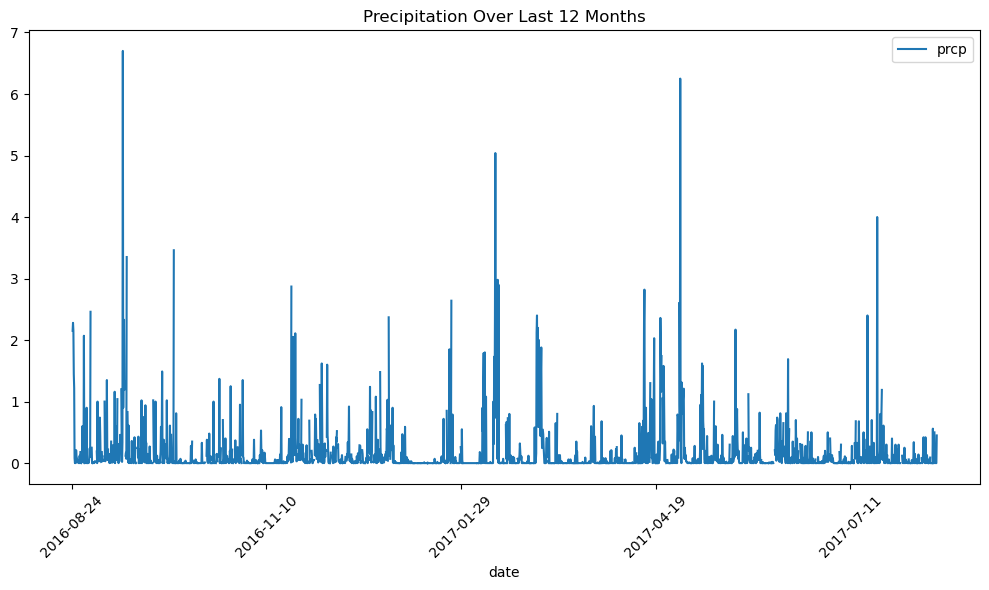

In [18]:
# Plot the precipitation data
precip_df.plot(x="date", y="prcp", figsize=(10, 6), title="Precipitation Over Last 12 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
# Print summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Query the total number of stations using the correct syntax for Table objects
total_stations = session.query(func.count(Station.c.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [25]:
# List the stations and observation counts in descending order
active_stations = session.query(Measurement.c.station, func.count(Measurement.c.date)).\
    group_by(Measurement.c.station).\
    order_by(func.count(Measurement.c.date).desc()).all()

# Print the most-active station
most_active_station = active_stations[0][0]
print(f"Most active station: {most_active_station}")
print(active_stations)


Most active station: USC00519281
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [29]:
# Query the lowest, highest, and average temperatures for the most-active station
temp_stats = session.query(
    func.min(Measurement.c.tobs),
    func.max(Measurement.c.tobs),
    func.avg(Measurement.c.tobs)
).filter(Measurement.c.station == most_active_station).all()

print(f"Temperature stats for station {most_active_station}: {temp_stats}")

Temperature stats for station USC00519281: [(54, 85, 71.66378066378067)]


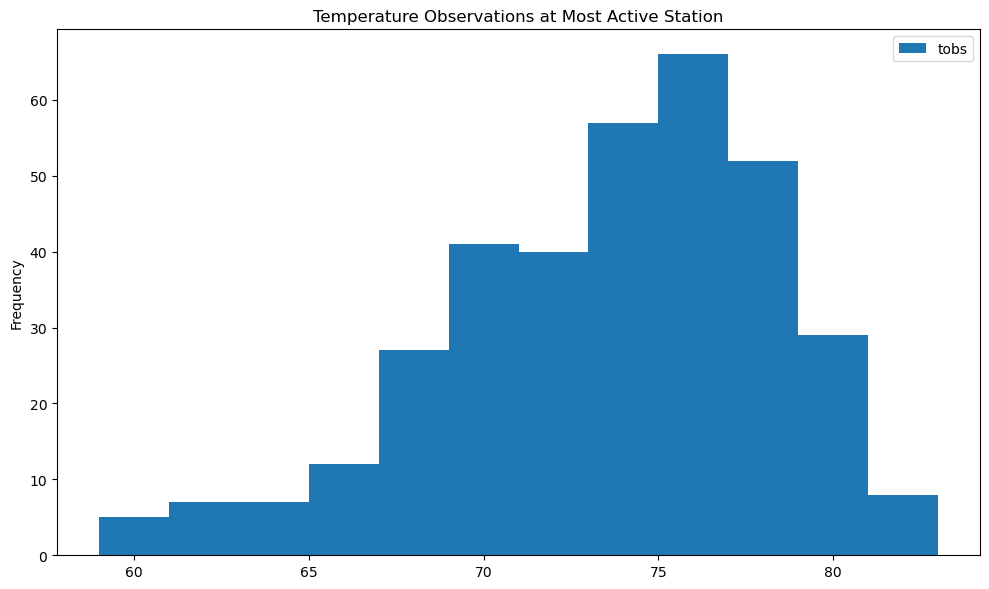

In [30]:
# Query the previous 12 months of TOBS data for the most-active station
tobs_data = session.query(Measurement.c.tobs).\
    filter(Measurement.c.station == most_active_station).\
    filter(Measurement.c.date >= one_year_ago).all()

# Convert the data into a DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["tobs"])

# Plot the TOBS data as a histogram with 12 bins
tobs_df.plot.hist(bins=12, figsize=(10, 6), title="Temperature Observations at Most Active Station")
plt.tight_layout()
plt.show()


In [31]:
# Close the session
session.close()